In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.8.0
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.0
keras.api._v2.keras 2.8.0


In [3]:
!nvidia-smi

Thu May 19 07:56:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# 数据加载
imdb = keras.datasets.imdb
vocab_size = 10000  # 出现频率最高的1w个词
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

17473536/17464789 [==============================] - 0s 0us/step


In [5]:
word_index = imdb.get_word_index()
print(len(word_index))

1654784/1641221 [==============================] - 0s 0us/step
88584


In [6]:
word_index = {k:(v+3) for k, v in word_index.items()}

In [7]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,  # list of list
    value = word_index['<PAD>'],
    padding = 'post',  # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,  # list of list
    value = word_index['<PAD>'],
    padding = 'post',  # post, pre
    maxlen = max_length)

print(train_data[1])

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

# RNN实现

In [9]:
# 还是类似于全连接神经网络，只不过改变了内部的运算
embedding_dim = 16
batch_size = 512  # batch_size大或小的选择，利弊？
# 相对于之前主要改的是这里
single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]  10000*16
    # 2. [1,2,3,4..], max_length * embedding_dim  500*16
    # 3. batch_size * max_length * embedding_dim  512*500*16
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),  # 10000，16，500
    # return_sequences是返回输出序列中的最后一个输出还是完整序列,False就是返回最后一个
    keras.layers.SimpleRNN(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',  # 二分类问题 若用它解决多分类呢？->多次二分类
                         metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5184      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [10]:
16*64+64*64+64  # 当前状态+前一个状态+偏置

5184

In [11]:
64*64+64

4160

In [12]:
single_rnn_model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.00172949, -0.03155132, -0.03176705, ..., -0.01218706,
         -0.01056673, -0.01327542],
        [ 0.04327894, -0.00691332,  0.01458103, ...,  0.04417452,
         -0.03650909,  0.02287446],
        [-0.0482919 ,  0.00857639, -0.02317165, ..., -0.02825735,
         -0.01973406, -0.02649883],
        ...,
        [-0.04760519, -0.01048294,  0.0478176 , ...,  0.04888568,
         -0.006774  , -0.00975468],
        [ 0.00233742, -0.00572407, -0.03328405, ...,  0.04605367,
          0.03493175, -0.02463394],
        [ 0.00632796, -0.03083906, -0.00424059, ...,  0.00834424,
          0.0036686 , -0.04434433]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[ 0.15470865,  0.02336088,  0.16596118, ..., -0.10567367,
         -0.1119736 ,  0.22972304],
        [ 0.24942344, -0.21691617, -0.13659255, ..., -0.16416383,
          0.17293042,

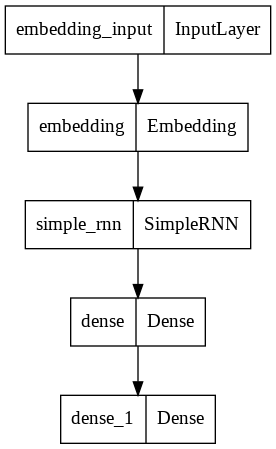

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(single_rnn_model)

In [14]:
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    # 我们这里和之前不一样，没有验证集，所以分20%给验证集
    validation_split = 0.2)


Epoch 1/30
40/40 [==============================] - 34s 739ms/step - loss: 0.6946 - accuracy: 0.5001 - val_loss: 0.6940 - val_accuracy: 0.4938
Epoch 2/30
40/40 [==============================] - 30s 747ms/step - loss: 0.6954 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5036
Epoch 3/30
40/40 [==============================] - 30s 761ms/step - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6932 - val_accuracy: 0.5060
Epoch 4/30
40/40 [==============================] - 30s 753ms/step - loss: 0.6954 - accuracy: 0.4985 - val_loss: 0.6942 - val_accuracy: 0.5144
Epoch 5/30
40/40 [==============================] - 29s 731ms/step - loss: 0.6995 - accuracy: 0.4965 - val_loss: 0.7245 - val_accuracy: 0.4918
Epoch 6/30
40/40 [==============================] - 31s 766ms/step - loss: 0.6988 - accuracy: 0.5020 - val_loss: 0.7003 - val_accuracy: 0.5064
Epoch 7/30
40/40 [==============================] - 30s 738ms/step - loss: 0.6984 - accuracy: 0.4974 - val_loss: 0.6951 - val_accuracy: 0.5068

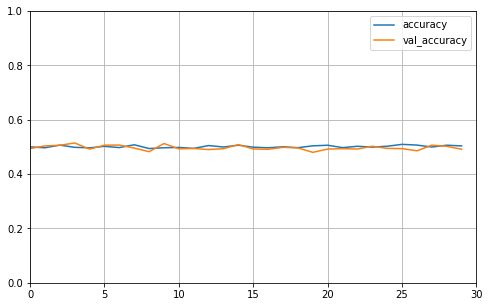

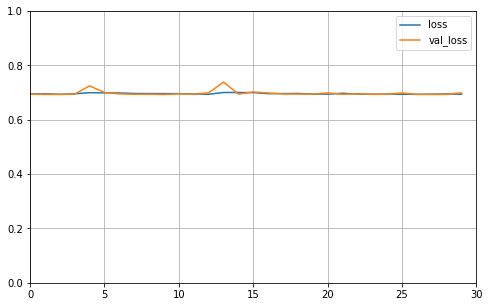

In [15]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy', 30, 0, 1)
plot_learning_curves(history_single_rnn, 'loss', 30, 0, 1)

In [16]:
single_rnn_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,
    verbose = 0)

[0.6976284980773926, 0.49744001030921936]

In [17]:
# 如果我们实现双向的rnn是不是会好一些
embedding_dim = 16
batch_size = 512

model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    # Bidirectional代表双向rnn，前面的计算会受到后面样本的影响
    # 双向双层
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = True)),  # 这个为什么是True？下面还有一层，如果写成False的话，下一层输入就不是一个seq了
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 64, return_sequences = False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(optimizer = 'adam',
              # 当只有两个标签类别（假定为0和1）时，使用此交叉熵损失
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 128)         10368     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              24704     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 203,393
Trainable params: 203,393
Non-tr

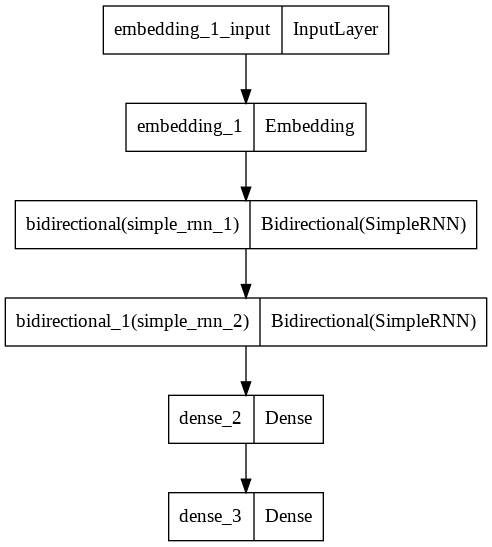

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [19]:
(16*64+64*64+64)*2

10368

In [20]:
(128*64+64*64+64)*2

24704

In [21]:
model.variables

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.02842445,  0.01088173,  0.04559788, ...,  0.04791046,
          0.0480943 , -0.00315152],
        [ 0.01946757, -0.04401151, -0.04124771, ..., -0.00344541,
         -0.0311373 ,  0.02682564],
        [-0.03897698, -0.04902573,  0.0111958 , ...,  0.03451497,
          0.01955029,  0.00968703],
        ...,
        [ 0.00492341, -0.04758812, -0.00467341, ..., -0.01590767,
         -0.00357714, -0.03810576],
        [ 0.01245847, -0.04806328, -0.03645558, ..., -0.01728994,
          0.03740131,  0.04597428],
        [-0.01010022, -0.00314913,  0.0438638 , ..., -0.03150934,
          0.0284618 , -0.02418741]], dtype=float32)>,
 <tf.Variable 'bidirectional/forward_simple_rnn_1/simple_rnn_cell_2/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-0.14807424, -0.271761  , -0.27379233, ..., -0.11827984,
          0.1406315 ,  0.25382084],
        [-0.09628601,  0.05849493, -0.15137404, ..., -0.213

In [22]:
history = model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


Epoch 1/30
40/40 [==============================] - 120s 3s/step - loss: 0.6952 - accuracy: 0.5046 - val_loss: 0.6964 - val_accuracy: 0.4938
Epoch 2/30
40/40 [==============================] - 116s 3s/step - loss: 0.6949 - accuracy: 0.5311 - val_loss: 0.7339 - val_accuracy: 0.5090
Epoch 3/30
40/40 [==============================] - 115s 3s/step - loss: 0.6694 - accuracy: 0.5892 - val_loss: 0.6901 - val_accuracy: 0.5536
Epoch 4/30
40/40 [==============================] - 116s 3s/step - loss: 0.6052 - accuracy: 0.6725 - val_loss: 0.7117 - val_accuracy: 0.5632
Epoch 5/30
40/40 [==============================] - 117s 3s/step - loss: 0.5240 - accuracy: 0.7406 - val_loss: 0.8217 - val_accuracy: 0.5496
Epoch 6/30
40/40 [==============================] - 116s 3s/step - loss: 0.4289 - accuracy: 0.8054 - val_loss: 0.8303 - val_accuracy: 0.5658
Epoch 7/30
40/40 [==============================] - 114s 3s/step - loss: 0.3538 - accuracy: 0.8478 - val_loss: 1.0346 - val_accuracy: 0.5522
Epoch 8/30
40

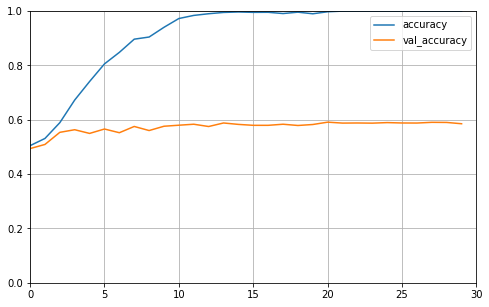

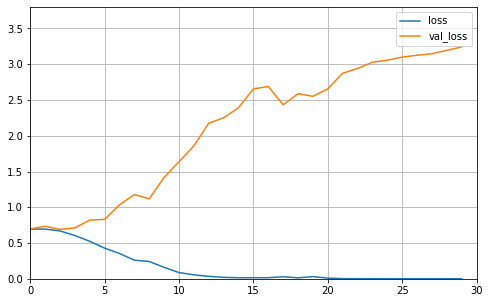

In [23]:
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 3.8)
# 我们发现过拟合了，可能是模型太复杂了，我们改为单层的rnn

In [24]:
embedding_dim = 16
batch_size = 512

bi_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.SimpleRNN(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               3136      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)

Epoch 1/30
40/40 [==============================] - 61s 1s/step - loss: 0.6936 - accuracy: 0.5065 - val_loss: 0.6899 - val_accuracy: 0.5390
Epoch 2/30
40/40 [==============================] - 59s 1s/step - loss: 0.6602 - accuracy: 0.6160 - val_loss: 0.6326 - val_accuracy: 0.6330
Epoch 3/30
40/40 [==============================] - 58s 1s/step - loss: 0.4857 - accuracy: 0.7772 - val_loss: 0.4450 - val_accuracy: 0.8020
Epoch 4/30
40/40 [==============================] - 59s 1s/step - loss: 0.3422 - accuracy: 0.8627 - val_loss: 0.4130 - val_accuracy: 0.8228
Epoch 5/30
40/40 [==============================] - 59s 1s/step - loss: 0.2623 - accuracy: 0.9000 - val_loss: 0.3526 - val_accuracy: 0.8638
Epoch 6/30
40/40 [==============================] - 58s 1s/step - loss: 0.2065 - accuracy: 0.9255 - val_loss: 0.3852 - val_accuracy: 0.8580
Epoch 7/30
40/40 [==============================] - 60s 1s/step - loss: 0.1596 - accuracy: 0.9465 - val_loss: 0.4895 - val_accuracy: 0.8428
Epoch 8/30
40/40 [==

In [ ]:
plot_learning_curves(history, 'accuracy', 30, 0, 1.1)
plot_learning_curves(history, 'loss', 30, 0, 2.5)

In [ ]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size, verbose = 0)

In [ ]:
# 最终效果变好了，但是仍然过拟合，过拟合说明我们的模型很强大

In [29]:
# 交叉熵损失手算
y_true = [[0, 1]]
y_pred = [[0.6, 0.4]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
# assert loss.shape == (2,)
loss.numpy()

array([0.9162905], dtype=float32)

In [30]:
1*np.log(0.4)

-0.916290731874155

In [31]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
print(inputs)

simple_rnn = tf.keras.layers.SimpleRNN(4)
output = simple_rnn(inputs)  # The output has shape `[32, 4]`.
print(output)
simple_rnn = tf.keras.layers.SimpleRNN(
    4, return_sequences=False, return_state=True)

# whole_sequence_output has shape `[32, 4]`.
# final_state has shape `[32, 4]`.
whole_sequence_output, final_state = simple_rnn(inputs)

[[[4.04743224e-01 8.21743429e-01 9.39467847e-01 ... 6.20183706e-01
   1.33804902e-01 8.24728906e-01]
  [5.29909372e-01 3.93406898e-01 1.88047230e-01 ... 1.76617250e-01
   1.12405634e-02 4.49777752e-01]
  [8.83900404e-01 6.71050668e-01 1.99225143e-01 ... 3.88529241e-01
   1.94356784e-01 6.63951099e-01]
  ...
  [8.90123248e-01 5.93836725e-01 5.16860306e-01 ... 9.52417016e-01
   2.24758670e-01 9.79766548e-01]
  [3.06025237e-01 8.07701826e-01 9.58860338e-01 ... 9.07456994e-01
   4.13412452e-01 2.74034947e-01]
  [3.30029756e-01 3.92924398e-01 4.07558441e-01 ... 5.47455788e-01
   3.42911094e-01 7.30299890e-01]]

 [[8.10558349e-02 3.75980377e-01 6.50673330e-01 ... 1.40769526e-01
   3.50623488e-01 2.65775800e-01]
  [4.04584110e-01 8.52976918e-01 8.76205742e-01 ... 1.96106270e-01
   3.78300428e-01 5.33275425e-01]
  [3.92455161e-01 6.88890398e-01 9.38368082e-01 ... 2.23749951e-01
   5.29215991e-01 7.13358402e-01]
  ...
  [2.88096461e-02 7.44643033e-01 9.07582700e-01 ... 3.81169707e-01
   1.52762

In [32]:
print(whole_sequence_output)
final_state

tf.Tensor(
[[-0.93549573  0.6985805  -0.6064644  -0.7973036 ]
 [-0.9067718  -0.19761172 -0.968982   -0.9293767 ]
 [-0.7590022   0.93275595 -0.85118186 -0.95104617]
 [-0.8841325   0.4910398  -0.93803024 -0.9490592 ]
 [-0.94718546  0.30267435 -0.6442682  -0.8142085 ]
 [-0.9323764   0.53506655 -0.6844748  -0.7333868 ]
 [-0.8991744   0.14297397 -0.8925509  -0.99348086]
 [-0.9496955   0.8255236  -0.38951787 -0.93224245]
 [-0.89263535  0.48366997 -0.86993647 -0.9172053 ]
 [-0.87313116  0.5190113  -0.7949161  -0.9360023 ]
 [-0.85957575  0.18347666 -0.84784865 -0.8578296 ]
 [-0.9074682   0.94015723 -0.66703737 -0.71856385]
 [-0.8559746   0.797144   -0.8412878  -0.9296974 ]
 [-0.85651445  0.4276889  -0.90715176 -0.9275726 ]
 [-0.799033    0.7148656  -0.74588174 -0.9469213 ]
 [-0.93407315  0.5142935  -0.7235933  -0.9317691 ]
 [-0.85998726  0.7076067  -0.84866506 -0.79170305]
 [-0.9455445   0.00574718 -0.8384172  -0.97894996]
 [-0.9012729   0.7731476  -0.83869225 -0.6046801 ]
 [-0.8908063   0.590

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[-0.93549573,  0.6985805 , -0.6064644 , -0.7973036 ],
       [-0.9067718 , -0.19761172, -0.968982  , -0.9293767 ],
       [-0.7590022 ,  0.93275595, -0.85118186, -0.95104617],
       [-0.8841325 ,  0.4910398 , -0.93803024, -0.9490592 ],
       [-0.94718546,  0.30267435, -0.6442682 , -0.8142085 ],
       [-0.9323764 ,  0.53506655, -0.6844748 , -0.7333868 ],
       [-0.8991744 ,  0.14297397, -0.8925509 , -0.99348086],
       [-0.9496955 ,  0.8255236 , -0.38951787, -0.93224245],
       [-0.89263535,  0.48366997, -0.86993647, -0.9172053 ],
       [-0.87313116,  0.5190113 , -0.7949161 , -0.9360023 ],
       [-0.85957575,  0.18347666, -0.84784865, -0.8578296 ],
       [-0.9074682 ,  0.94015723, -0.66703737, -0.71856385],
       [-0.8559746 ,  0.797144  , -0.8412878 , -0.9296974 ],
       [-0.85651445,  0.4276889 , -0.90715176, -0.9275726 ],
       [-0.799033  ,  0.7148656 , -0.74588174, -0.9469213 ],
       [-0.93407315,  0.5142935 , -0